In [1]:
%run ./PPS_Expansion_Model.ipynb

In [2]:
# Distance points in cm (network coordinates)
s_distances = np.asarray([2700, 2200, 1500, 800, 300]) / 1000
ts = np.linspace(s_distances[0], s_distances[-1], 15)
v = 30  # cm/s
a_distances = 100 - ts * v  # distance points in cm (network coordinates)

ts = 0.4
simtime = 200

In [3]:
##Pre-Training
###SCZ
ymin = 382.5
ymax = 429.5
scz_cp = 100 - 1.6415 * 30
scz_slope = 1 / 0.0450

SCZ_RTs = RTsig(a_distances, scz_cp, scz_slope)

##Post-Training
###SCZ
ymin = 373.0
ymax = 455.0
scz_cp_post = 100 - 1.176 * v
scz_slope_post = 1 / 0.0615

SCZ_RTs_post = RTsig(a_distances, scz_cp_post, scz_slope_post)

In [4]:
k_a = 5e-05
k_v = 5e-05
stim_counts = 10
locav_x = 60
siga_x, sigv_x = 6.992e01, 2.889e00

HCWat, HCWvt, HCWav = cross_modal(at=0.05, sigat=2, vt=0.05, sigvt=2, av=0.05, sigav=2)
HCWt, HCWa, HCWv, HCBt, HCBa, HCBv = FwFb(
    Wt_0=6.5,
    Wa_0=6.5,
    Wv_0=6.5,
    Bt_0=2.5,
    Ba_0=2.5,
    Bv_0=2.5,
    k1=2.603e01,
    k2=7.795e02,
    lim=2.009e01,
    alpha=9.415e-01,
)

## SCZ Pre-training model

In [5]:
## Fitted model

Lex, Pr = 7.886e-01, 0

SCZLt, SCZLa, SCZLv = Lw(
    Lex_t=Lex,
    Lin_t=0.05,
    sigmaex_t=1,
    sigmain_t=4,
    Lex_a=Lex,
    Lin_a=0.05,
    sigmaex_a=20,
    sigmain_a=80,
    Lex_v=Lex,
    Lin_v=0.05,
    sigmaex_v=1,
    sigmain_v=4,
)

_, _, _, _, SCZ_Model_RTs = experiment(
    ts=ts,
    T=simtime,
    dist=a_distances,
    ya=5,
    Lt=SCZLt,
    La=SCZLa,
    Lv=SCZLv,
    Wt=HCWt,
    Wa=HCWa,
    Wv=HCWv,
    Bt=HCBt,
    Ba=HCBa,
    Bv=HCBv,
    Wat=HCWat,
    Wvt=HCWvt,
    Wav=HCWav,
    FWpr=Pr,
    CMpr=0,
)

SCZ_RTs_model_pre_scaled = fit_RT(xf=SCZ_Model_RTs, yf=SCZ_RTs)

## SCZ Post-training model

In [6]:
## Fitted model

Lex, Pr = 7.887e-01, 4.773e-01
rho_0 = 6.137e-02

SCZLt, SCZLa, SCZLv = Lw(
    Lex_t=Lex,
    Lin_t=0.05,
    sigmaex_t=1,
    sigmain_t=4,
    Lex_a=Lex,
    Lin_a=0.05,
    sigmaex_a=20,
    sigmain_a=80,
    Lex_v=Lex,
    Lin_v=0.05,
    sigmaex_v=1,
    sigmain_v=4,
)

SCZWa_tr, SCZWv_tr, _, _, _, _ = FWTraining(
    n_steps=stim_counts,
    T=simtime,
    ts=ts,
    Lt=SCZLt,
    La=SCZLa,
    Lv=SCZLv,
    Wt=HCWt,
    Wa=HCWa,
    Wv=HCWv,
    Bt=HCBt,
    Ba=HCBa,
    Bv=HCBv,
    Wat=HCWat,
    Wvt=HCWvt,
    Wav=HCWav,
    FWpr=Pr,
    rho_0=rho_0,
    Wmax_a=6.5,
    Wmax_v=6.5,
    k_a=k_a,
    k_v=k_v,
    theta=0.05,
    locav_x=locav_x,
    siga_x=siga_x,
    sigv_x=sigv_x,
)

_, _, _, _, SCZ_Model_RTs_post = experiment(
    ts=ts,
    T=simtime,
    dist=a_distances,
    ya=5,
    Lt=SCZLt,
    La=SCZLa,
    Lv=SCZLv,
    Wt=HCWt,
    Wa=SCZWa_tr[:, :, -1, -1],
    Wv=SCZWv_tr[:, :, -1, -1],
    Bt=HCBt,
    Ba=HCBa,
    Bv=HCBv,
    Wat=HCWat,
    Wvt=HCWvt,
    Wav=HCWav,
    FWpr=0,
    CMpr=0,
)

SCZ_RTs_model_post_scaled = fit_RT(SCZ_Model_RTs_post, SCZ_RTs_post)

In [7]:
scz_error = calculate_adj_rmse(SCZ_RTs_model_post_scaled, SCZ_RTs_post, 3)
print(scz_error)

4.3596706767482605


## SCZ Post-training model - rho

In [8]:
Lex, Pr = 7.887e-01, 4.773e-01
rho_0 = 1.435e-02

SCZLt, SCZLa, SCZLv = Lw(
    Lex_t=Lex,
    Lin_t=0.05,
    sigmaex_t=1,
    sigmain_t=4,
    Lex_a=Lex,
    Lin_a=0.05,
    sigmaex_a=20,
    sigmain_a=80,
    Lex_v=Lex,
    Lin_v=0.05,
    sigmaex_v=1,
    sigmain_v=4,
)

SCZWa_tr, SCZWv_tr, _, _, _, _ = FWTraining(
    n_steps=stim_counts,
    T=simtime,
    ts=ts,
    Lt=SCZLt,
    La=SCZLa,
    Lv=SCZLv,
    Wt=HCWt,
    Wa=HCWa,
    Wv=HCWv,
    Bt=HCBt,
    Ba=HCBa,
    Bv=HCBv,
    Wat=HCWat,
    Wvt=HCWvt,
    Wav=HCWav,
    FWpr=Pr,
    rho_0=rho_0,
    Wmax_a=6.5,
    Wmax_v=6.5,
    k_a=k_a,
    k_v=k_v,
    theta=0.05,
    locav_x=locav_x,
    siga_x=siga_x,
    sigv_x=sigv_x,
)

_, _, _, _, SCZ_Model_RTs_post_rho = experiment(
    ts=ts,
    T=simtime,
    dist=a_distances,
    ya=5,
    Lt=SCZLt,
    La=SCZLa,
    Lv=SCZLv,
    Wt=HCWt,
    Wa=SCZWa_tr[:, :, -1, -1],
    Wv=SCZWv_tr[:, :, -1, -1],
    Bt=HCBt,
    Ba=HCBa,
    Bv=HCBv,
    Wat=HCWat,
    Wvt=HCWvt,
    Wav=HCWav,
    FWpr=0,
    CMpr=0,
)

SCZ_RTs_model_post_rho_scaled = fit_RT(SCZ_Model_RTs_post_rho, SCZ_RTs_post)

In [9]:
model_a_distances = np.linspace(a_distances[0], a_distances[-1], 100)

# Sigmoid for pre-training model
ymin, ymax = np.min(SCZ_RTs_model_pre_scaled), np.max(SCZ_RTs_model_pre_scaled)
SCZ_CP_Model_pre, SCZ_SLOPE_Model_pre = fitting(a_distances, SCZ_RTs_model_pre_scaled)
SCZ_Model_RTs_pre_fit = RTsig(model_a_distances, SCZ_CP_Model_pre, SCZ_SLOPE_Model_pre)

# Sigmoid for post-training model
ymin, ymax = np.min(SCZ_RTs_model_post_scaled), np.max(SCZ_RTs_model_post_scaled)
SCZ_CP_Model_post, SCZ_SLOPE_Model_post = fitting(
    a_distances, SCZ_RTs_model_post_scaled
)
SCZ_Model_RTs_post_fit = RTsig(
    model_a_distances, SCZ_CP_Model_post, SCZ_SLOPE_Model_post
)

# Sigmoid for post-training rho model
ymin, ymax = np.min(SCZ_RTs_model_post_rho_scaled), np.max(
    SCZ_RTs_model_post_rho_scaled
)
SCZ_CP_Model_post_rho, SCZ_SLOPE_Model_post_rho = fitting(
    a_distances, SCZ_RTs_model_post_rho_scaled
)
SCZ_Model_RTs_post_rho_fit = RTsig(
    model_a_distances, SCZ_CP_Model_post_rho, SCZ_SLOPE_Model_post_rho
)

In [10]:
import seaborn as sns

sns.set_context("paper")
sns.set_theme(
    style="ticks",
    palette=["black", "grey", "grey"],
    rc={"axes.labelsize": 14, "axes.labelweight": "bold"},
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


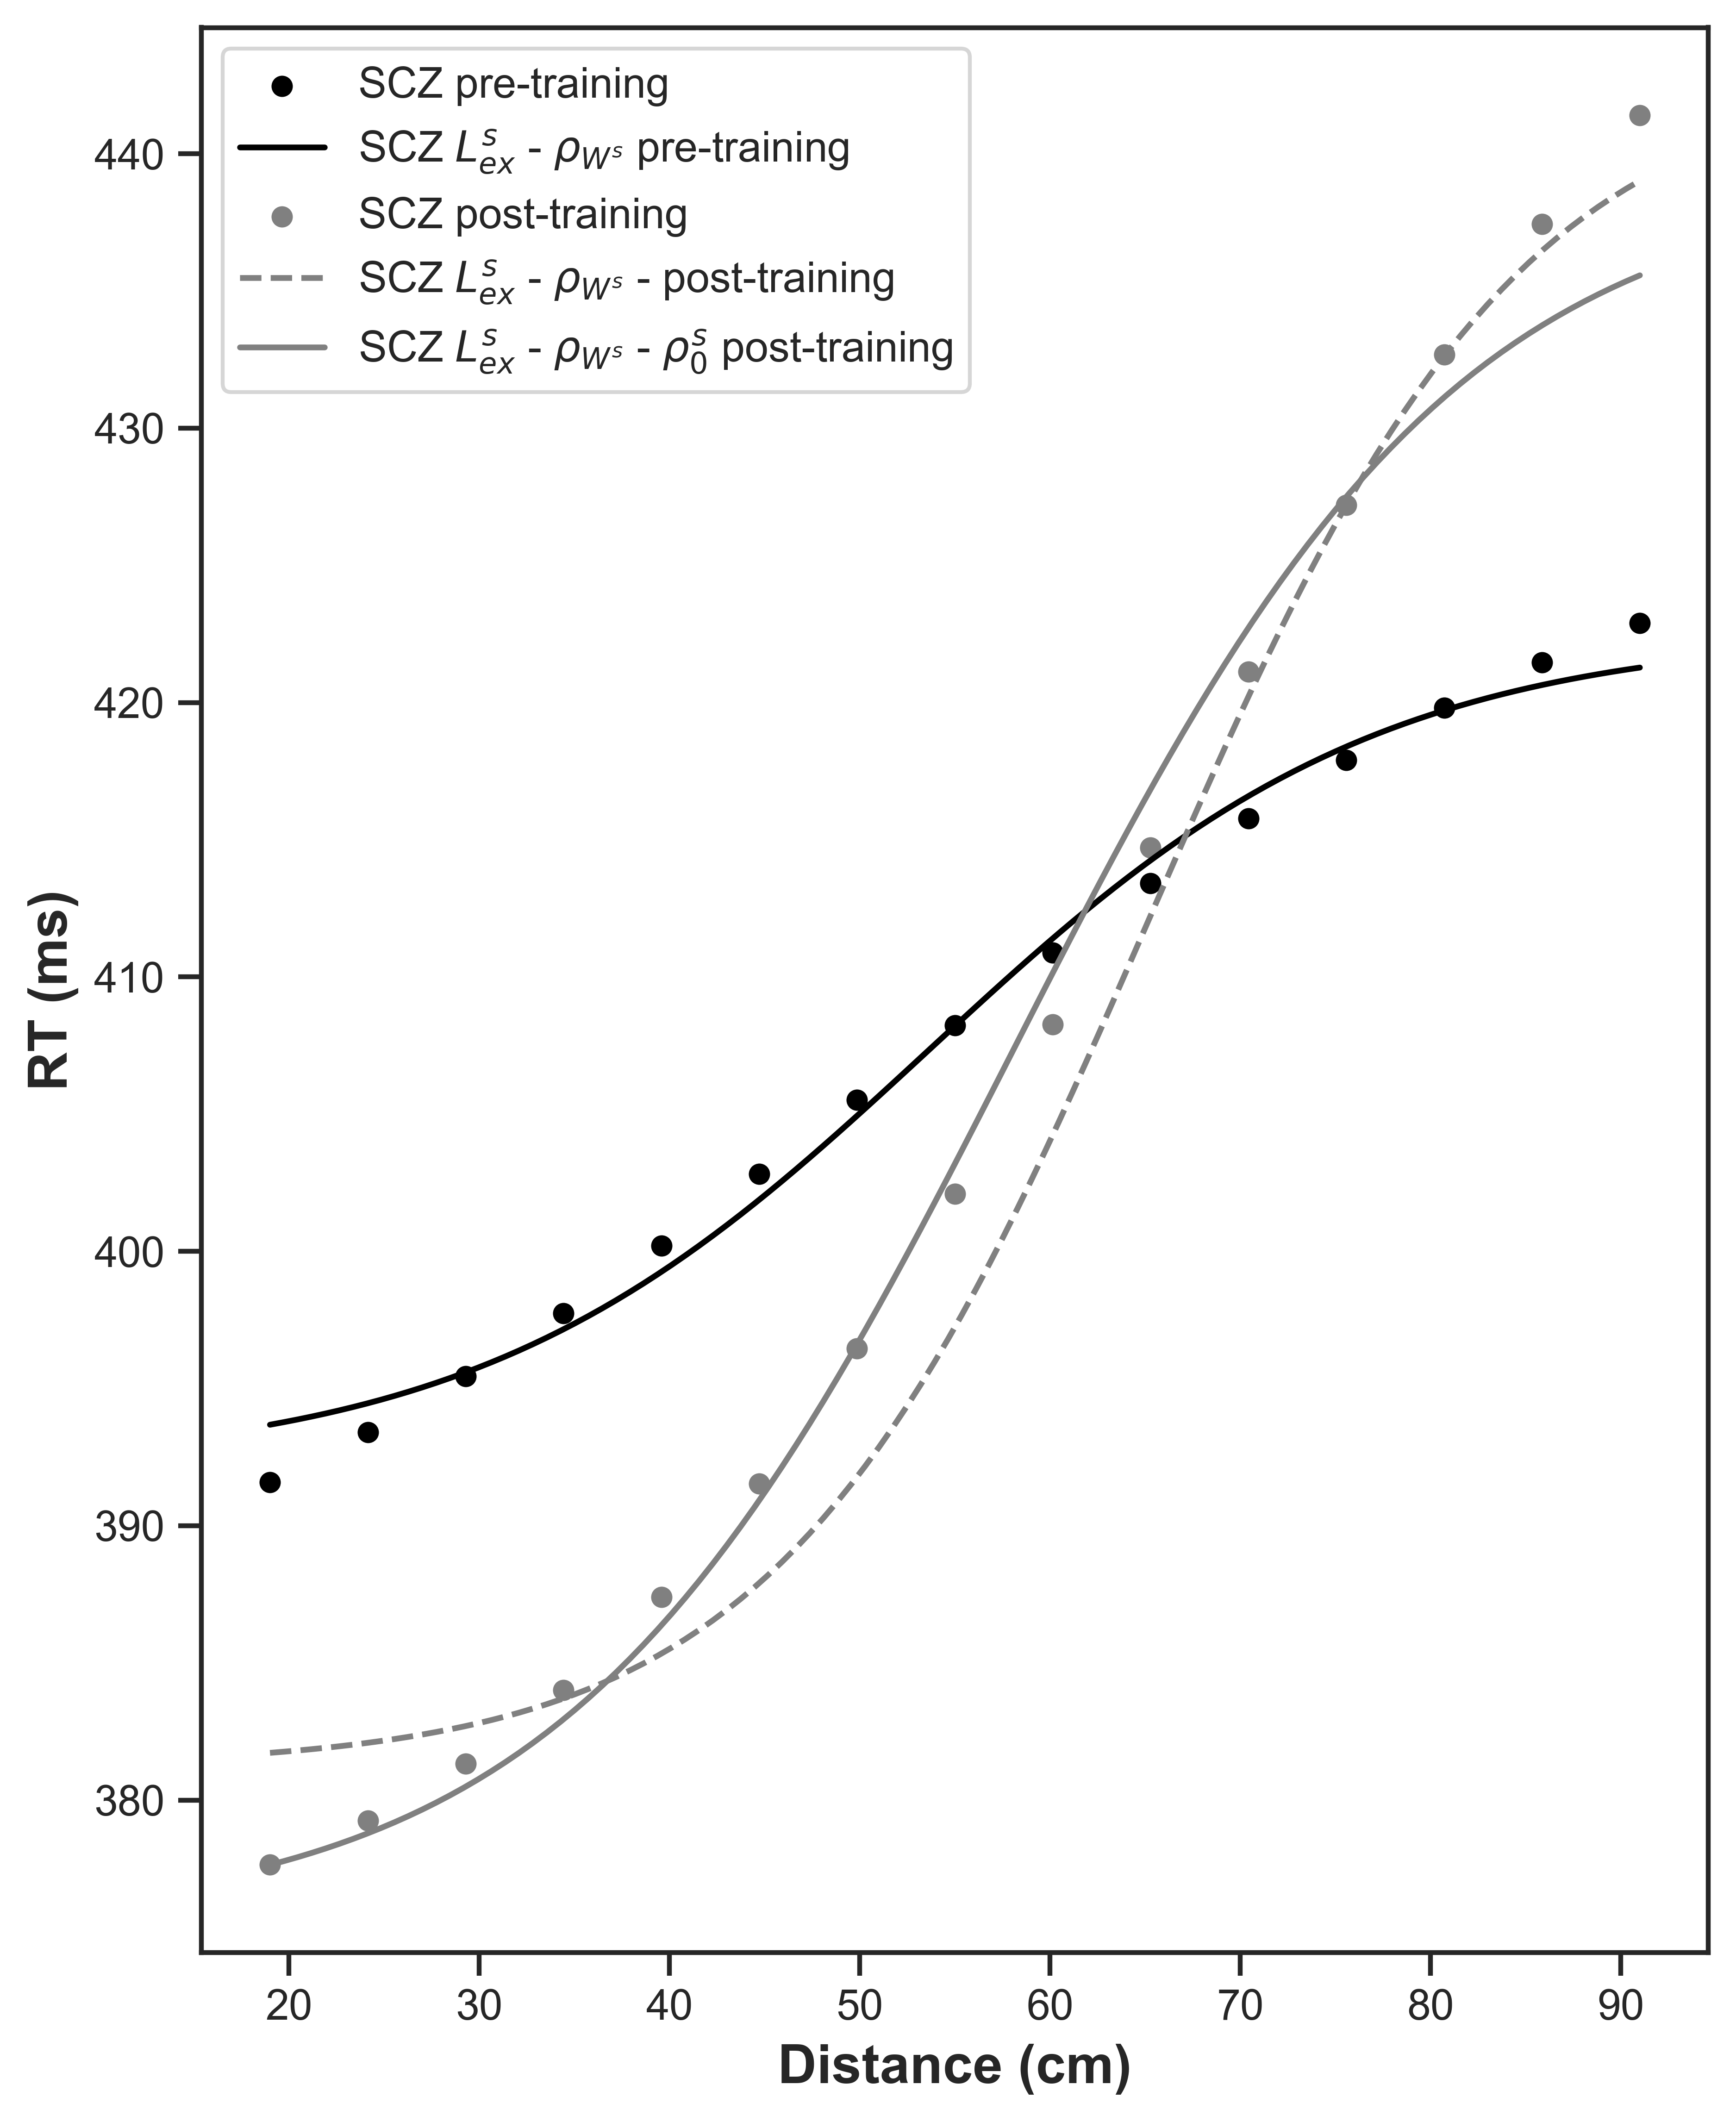

In [21]:
fig, axs = plt.subplots(1, 1, figsize=(7, 9), dpi=600)
ax1 = plt.subplot(111)

sns.scatterplot(x=a_distances, y=SCZ_RTs, label="SCZ pre-training", ax=ax1)
sns.lineplot(
    x=model_a_distances,
    y=SCZ_Model_RTs_pre_fit,
    label="SCZ $L_{ex}^{s}$ - " + r"$\rho_{{W}^{s}}$ pre-training",
    ax=ax1,
)
sns.scatterplot(
    x=a_distances,
    y=SCZ_RTs_post,
    label="SCZ post-training",
    ax=ax1,
)
sns.lineplot(
    x=model_a_distances,
    y=SCZ_Model_RTs_post_fit,
    label="SCZ $L_{ex}^{s}$ - " + r"$\rho_{{W}^{s}}$ - post-training",
    ax=ax1,
    linestyle="--",
)
sns.lineplot(
    x=model_a_distances,
    y=SCZ_Model_RTs_post_rho_fit,
    label="SCZ $L_{ex}^{s}$ - "
    + r"$\rho_{{W}^{s}}$ - "
    + r"$\rho^{s}_{0}$ post-training",
    ax=ax1,
)

ax1.set_xlabel("Distance (cm)")
ax1.set_ylabel("RT (ms)")

fig.savefig("drafts/FIG3.eps", bbox_inches="tight", format="eps")

In [12]:
##Pre-Training
###HC
ymin = 270.0
ymax = 318.5
hc_cp = 100 - 1.448 * v
hc_slope = 1 / 0.0435

HC_RTs = RTsig(a_distances, hc_cp, hc_slope)

##Post-Training
###HC
ymin = 271.5
ymax = 326.5
hc_cp_post = 100 - 0.920 * v
hc_slope_post = 1 / 0.085

HC_RTs_post = RTsig(a_distances, hc_cp_post, hc_slope_post)

In [13]:
## Fitted model

rho_0 = 6.137e-02

HCLt, HCLa, HCLv = Lw(
    Lex_t=0.15,
    Lin_t=0.05,
    sigmaex_t=1,
    sigmain_t=4,
    Lex_a=0.15,
    Lin_a=0.05,
    sigmaex_a=20,
    sigmain_a=80,
    Lex_v=0.15,
    Lin_v=0.05,
    sigmaex_v=1,
    sigmain_v=4,
)

HCWa_tr, HCWv_tr, zm, zv, za, zt = FWTraining(
    n_steps=stim_counts,
    T=simtime,
    ts=ts,
    Lt=HCLt,
    La=HCLa,
    Lv=HCLv,
    Wt=HCWt,
    Wa=HCWa,
    Wv=HCWv,
    Bt=HCBt,
    Ba=HCBa,
    Bv=HCBv,
    Wat=HCWat,
    Wvt=HCWvt,
    Wav=HCWav,
    FWpr=0,
    rho_0=rho_0,
    Wmax_a=6.5,
    Wmax_v=6.5,
    k_a=k_a,
    k_v=k_v,
    theta=0.05,
    locav_x=locav_x,
    siga_x=siga_x,
    sigv_x=sigv_x,
)

_, _, _, _, HC_Model_RTs_post = experiment(
    ts=ts,
    T=simtime,
    dist=a_distances,
    ya=5,
    Lt=HCLt,
    La=HCLa,
    Lv=HCLv,
    Wt=HCWt,
    Wa=HCWa_tr[:, :, -1, -1],
    Wv=HCWv_tr[:, :, -1, -1],
    Bt=HCBt,
    Ba=HCBa,
    Bv=HCBv,
    Wat=HCWat,
    Wvt=HCWvt,
    Wav=HCWav,
    FWpr=0,
    CMpr=0,
)

HC_Model_RTs_post_scaled = fit_RT(HC_Model_RTs_post, HC_RTs_post)

_, _, _, _, HC_Model_RTs_pre = experiment(
    ts=ts,
    T=simtime,
    dist=a_distances,
    ya=5,
    Lt=HCLt,
    La=HCLa,
    Lv=HCLv,
    Wt=HCWt,
    Wa=HCWa,
    Wv=HCWv,
    Bt=HCBt,
    Ba=HCBa,
    Bv=HCBv,
    Wat=HCWat,
    Wvt=HCWvt,
    Wav=HCWav,
    FWpr=0,
    CMpr=0,
)

HC_RTs_model_pre_scaled = fit_RT(HC_Model_RTs_pre, HC_RTs)

In [14]:
model_a_distances = np.linspace(a_distances[0], a_distances[-1], 100)

ymin, ymax = np.min(HC_RTs_model_pre_scaled), np.max(HC_RTs_model_pre_scaled)
HC_CP_Model_pre, HC_SLOPE_Model_pre = fitting(a_distances, HC_RTs_model_pre_scaled)
HC_Model_RTs_pre_fit = RTsig(model_a_distances, HC_CP_Model_pre, HC_SLOPE_Model_pre)

ymin, ymax = np.min(HC_Model_RTs_post_scaled), np.max(HC_Model_RTs_post_scaled)
HC_CP_Model_post, HC_SLOPE_Model_post = fitting(a_distances, HC_Model_RTs_post_scaled)
HC_Model_RTs_post_fit = RTsig(model_a_distances, HC_CP_Model_post, HC_SLOPE_Model_post)

In [15]:
print("Delta CP:", HC_CP_Model_post - HC_CP_Model_pre)
print("Delta Slope:", 1 / HC_SLOPE_Model_post - 1 / HC_SLOPE_Model_pre)

Delta CP: 10.804113331110592
Delta Slope: 0.02758714623164578


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


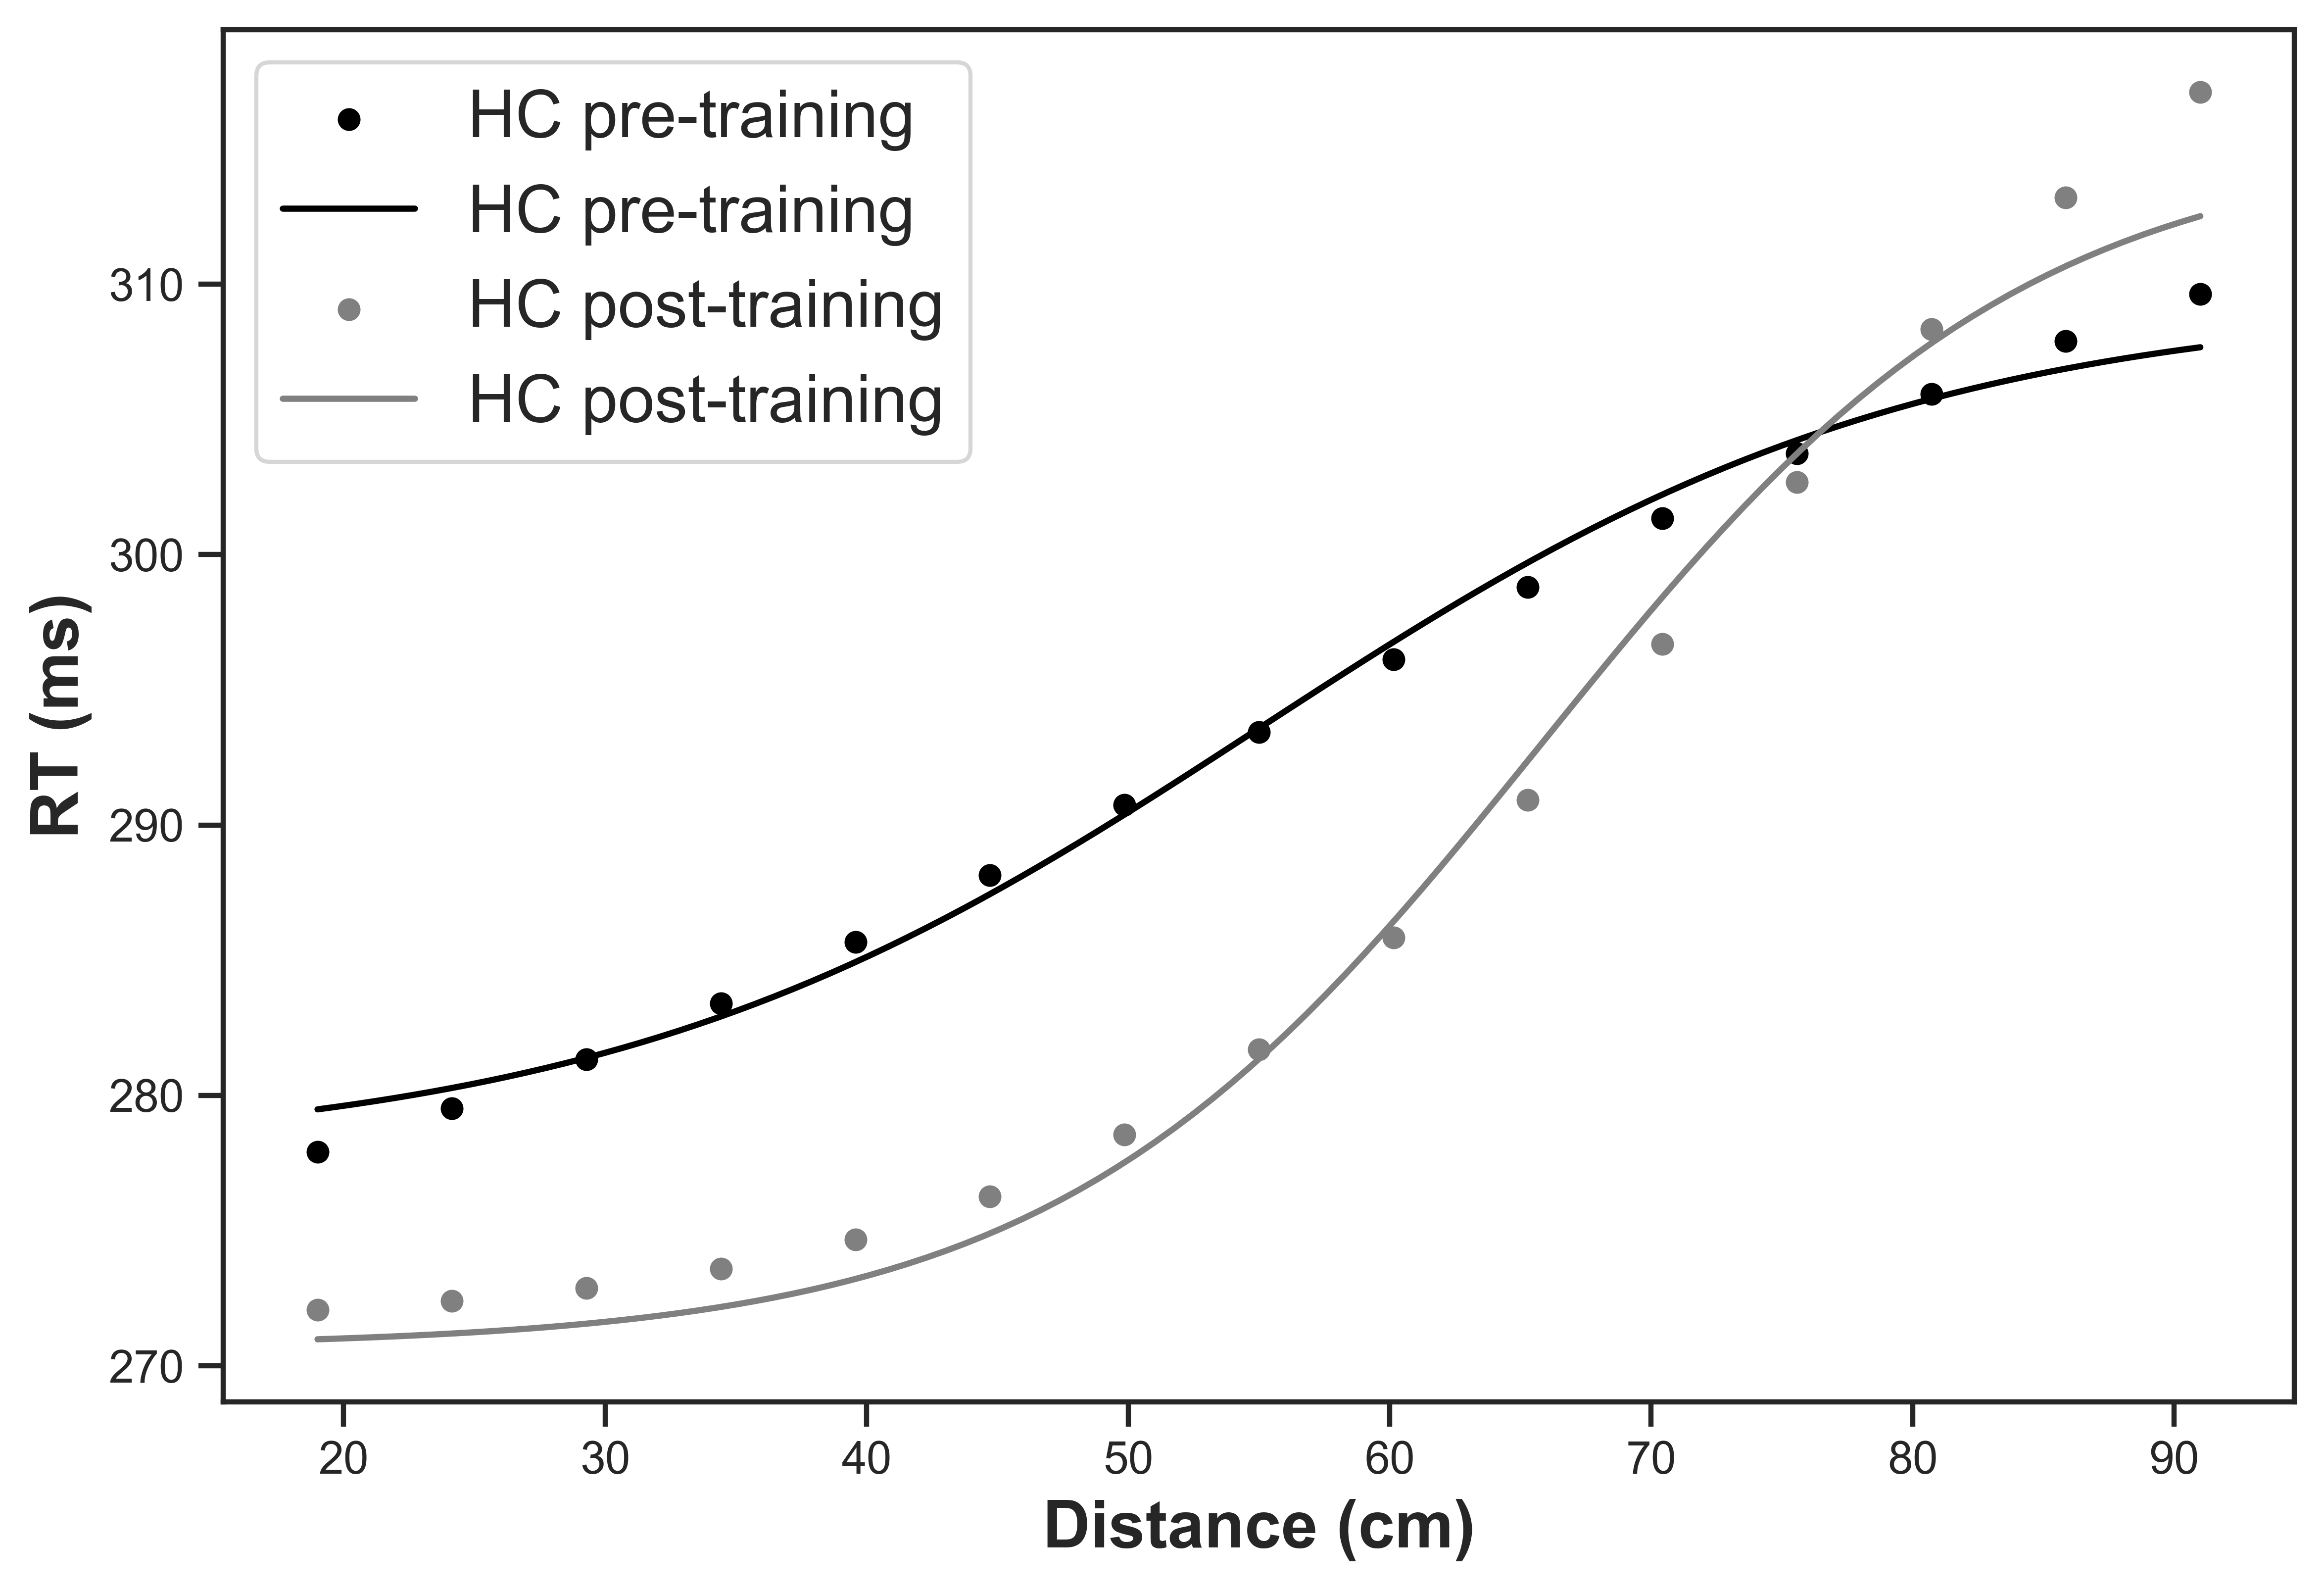

In [16]:
fig, axs = plt.subplots(1, 1, figsize=(9, 6), dpi=600)
ax1 = plt.subplot(111)

sns.scatterplot(x=a_distances, y=HC_RTs, label="HC pre-training", ax=ax1)
sns.lineplot(
    x=model_a_distances,
    y=HC_Model_RTs_pre_fit,
    label="HC pre-training",
    ax=ax1,
)
sns.scatterplot(x=a_distances, y=HC_RTs_post, label="HC post-training", ax=ax1)

sns.lineplot(
    x=model_a_distances,
    y=HC_Model_RTs_post_fit,
    label="HC post-training",
    ax=ax1,
)

ax1.set_xlabel("Distance (cm)", size=16)
ax1.set_ylabel("RT (ms)", size=16)

ax1.legend(fontsize=16)

fig.savefig("drafts/FIG0.eps", bbox_inches="tight", format="eps")